## Εισαγωγικά

In [45]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 

In [46]:
# Set random seed for reproducibility
import random
import os
SEED = 56
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x14DA2474640

In [47]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [48]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Keys in the dataset are formatted as such:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Keys in the dataset are formatted as such: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [49]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

# save the DataFrames to CSV files SO I DONT HAVE TO RELOAD THEM EVERY TIME
#df_train.to_csv('train_data.csv', index=False)
#df_val.to_csv('val_data.csv', index=False)
#df_test.to_csv('test_data.csv', index=False)

In [50]:
# Load data, IF YOU DONT WANT TO RELOAD THE DATA, COMMENT THIS OUT
df_train = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

Train images shape: (546, 50176)
Train labels shape: (546,)
Missing values in training data: 0

Validation images shape: (156, 50176)
Validation labels shape: (156,)
Missing values in validation data: 0

Test images shape: (78, 50176)
Test labels shape: (78,)
Missing values in test data: 0


Total number of images: 780, (546 (70.00%) train), (156 (20.00%) val), 78 (10.00)% test)
Number of positives: 399 train, 114 val, 57 test
Percentage of positives: 73.08% train, 73.08% val, 73.08% test
Number of negatives: 147 train, 42 val, 21 test
Percentage of negatives: 26.92% train, 26.92% val, 26.92% test


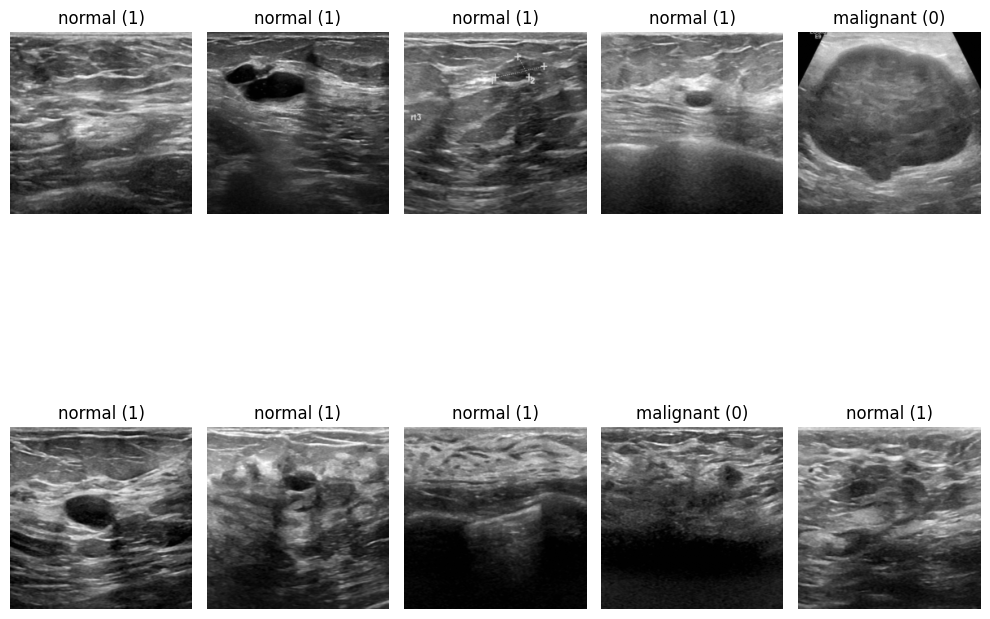

In [51]:

# Check the shapes of the arrays and DataFrames
print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Missing values in training data:", df_train.isnull().sum().sum())
print()
print("Validation images shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Missing values in validation data:", df_val.isnull().sum().sum())
print()
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)
print("Missing values in test data:", df_test.isnull().sum().sum())

"""# Display the first few rows of each DataFrame
print("Training DataFrame:")
print(df_train.head())

print("Validation DataFrame:")
print(df_val.head())

print("Test DataFrame:")
print(df_test.head())
"""

print("\n")
# Calculate the total number of images
num_train = len(x_train)
num_val = len(x_val)
num_test = len(x_test)
total_images = num_train + num_val + num_test
print(f"Total number of images: {total_images}, ({num_train} ({num_train /total_images * 100:.2f}%) train), ({num_val} ({num_val/total_images * 100:.2f}%) val), {num_test} ({num_test/total_images * 100:.2f})% test)")
print(f"Number of positives: {np.sum(y_train == 1)} train, {np.sum(y_val == 1)} val, {np.sum(y_test == 1)} test")
print(f"Percentage of positives: {np.mean(y_train == 1) * 100:.2f}% train, {np.mean(y_val == 1) * 100:.2f}% val, {np.mean(y_test == 1) * 100:.2f}% test")
print(f"Number of negatives: {np.sum(y_train == 0)} train, {np.sum(y_val == 0)} val, {np.sum(y_test == 0)} test")
print(f"Percentage of negatives: {np.mean(y_train == 0) * 100:.2f}% train, {np.mean(y_val == 0) * 100:.2f}% val, {np.mean(y_test == 0) * 100:.2f}% test")


# Display the first X images

images = data['train_images']
labels = data['train_labels']

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid for 10 images
    plt.imshow(images[i], cmap='gray')
    plt.title(f"{'normal (1)' if labels[i] == 1 else 'malignant (0)'}")
    plt.axis('off')

plt.tight_layout()
plt.show()


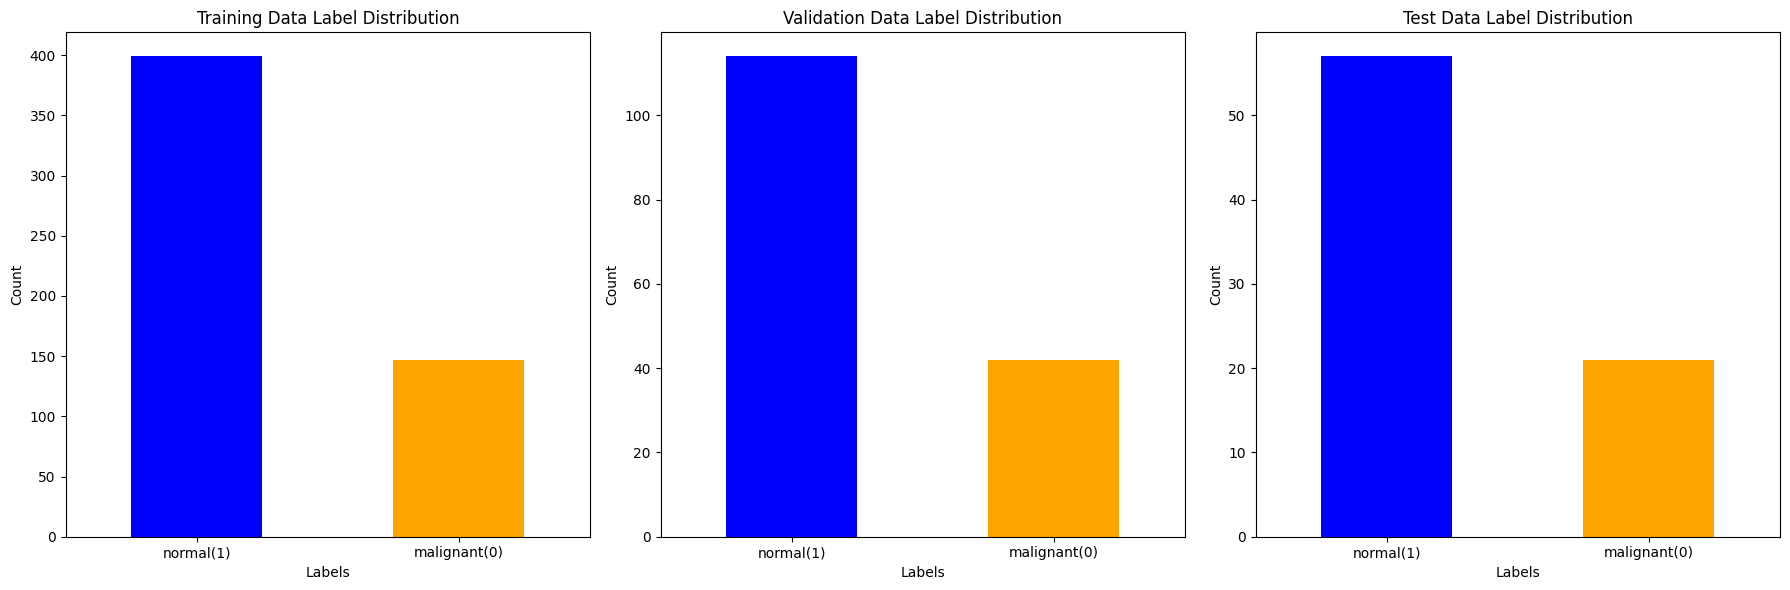

In [52]:
#PLOTS
# Convert the relevant data from the NpzFile object into a pandas DataFrame
# Create a row of 3 plots for the label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for training data
df_train['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Training Data Label Distribution')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels

# Plot for validation data
df_val['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Validation Data Label Distribution')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Plot for test data
df_test['Label'].value_counts().rename(index={1: 'normal', 0: 'malignant'}).plot(kind='bar', ax=axes[2], color=['blue', 'orange'])
axes[2].set_title('Test Data Label Distribution')
axes[2].set_xlabel('Labels')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['normal(1)', 'malignant(0)'], rotation=0)  # Set horizontal labels


# Adjust layout
plt.tight_layout()
plt.show()

In [53]:
# Ισως να το σβήσω αυτό, δεν είναι απαραίτητο
# Find extreme values (min and max) in the image datasets

print("Extreme values in train_images:")
print("  Min:", np.min(data['train_images']))
print("  Max:", np.max(data['train_images']))

print("Extreme values in val_images:")
print("  Min:", np.min(data['val_images']))
print("  Max:", np.max(data['val_images']))

print("Extreme values in test_images:")
print("  Min:", np.min(data['test_images']))
print("  Max:", np.max(data['test_images']))

# For all images combined
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
print("Extreme values in all images:")
print("  Min:", np.min(all_images))
print("  Max:", np.max(all_images))

Extreme values in train_images:
  Min: 0
  Max: 255
Extreme values in val_images:
  Min: 0
  Max: 255
Extreme values in test_images:
  Min: 0
  Max: 255
Extreme values in all images:
  Min: 0
  Max: 255


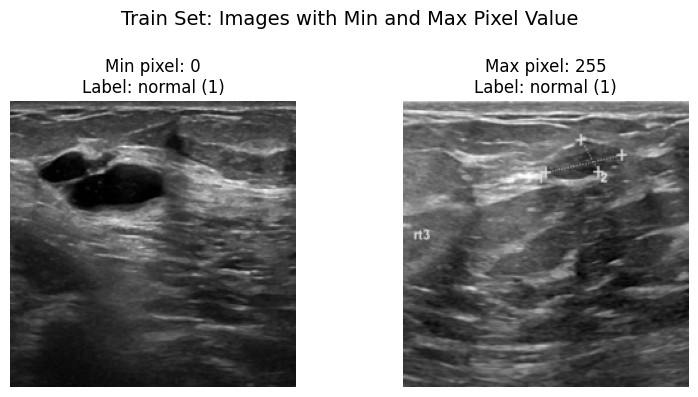

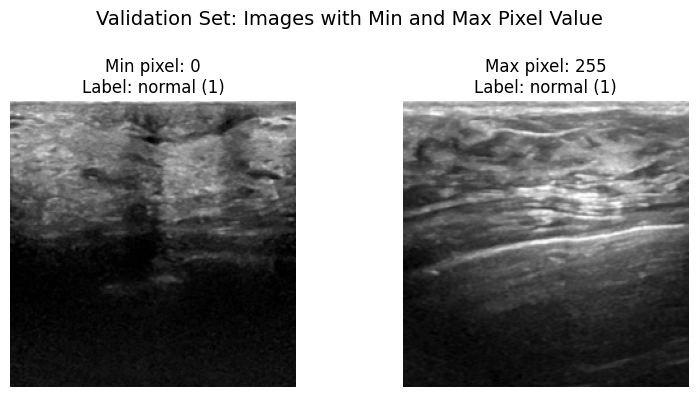

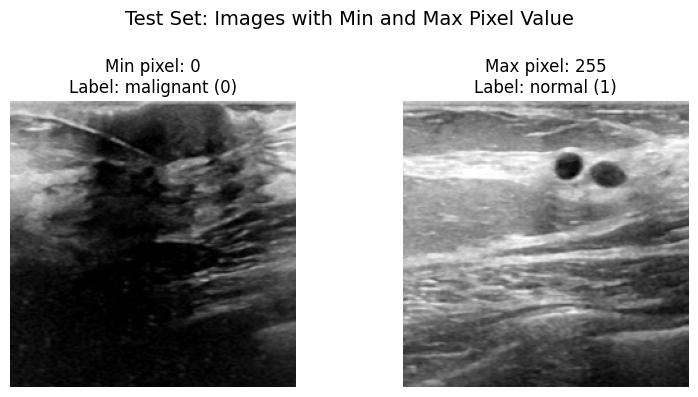

In [54]:
datasets = {
    'Train': (data['train_images'], data['train_labels']),
    'Validation': (data['val_images'], data['val_labels']),
    'Test': (data['test_images'], data['test_labels'])
}

for name, (images, labels) in datasets.items():
    # Find the image with the minimum pixel value
    min_pixel_idx = np.argmin(images.reshape(images.shape[0], -1).min(axis=1))
    max_pixel_idx = np.argmax(images.reshape(images.shape[0], -1).max(axis=1))
    min_pixel_val = images[min_pixel_idx].min()
    max_pixel_val = images[max_pixel_idx].max()
    min_label = labels[min_pixel_idx]
    max_label = labels[max_pixel_idx]
    min_label_str = "malignant (0)" if min_label == 0 else "normal (1)"
    max_label_str = "malignant (0)" if max_label == 0 else "normal (1)"

    plt.figure(figsize=(8, 4))
    plt.suptitle(f'{name} Set: Images with Min and Max Pixel Value', fontsize=14)
    plt.subplot(1, 2, 1)
    plt.imshow(images[min_pixel_idx], cmap='gray')
    plt.title(f'Min pixel: {min_pixel_val}\nLabel: {min_label_str}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(images[max_pixel_idx], cmap='gray')
    plt.title(f'Max pixel: {max_pixel_val}\nLabel: {max_label_str}')
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

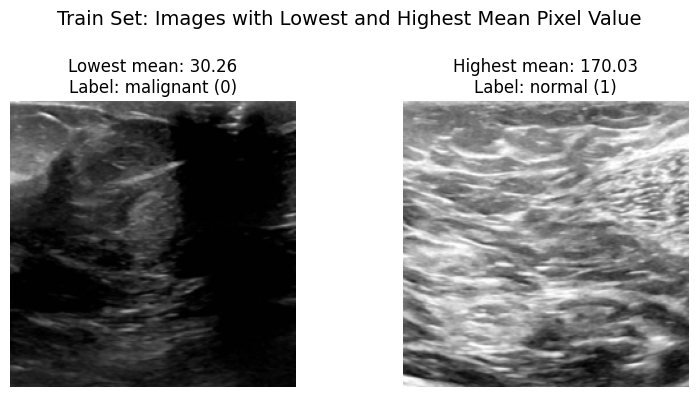

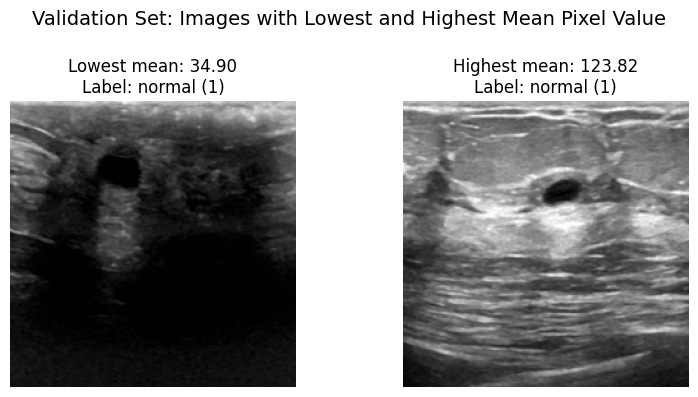

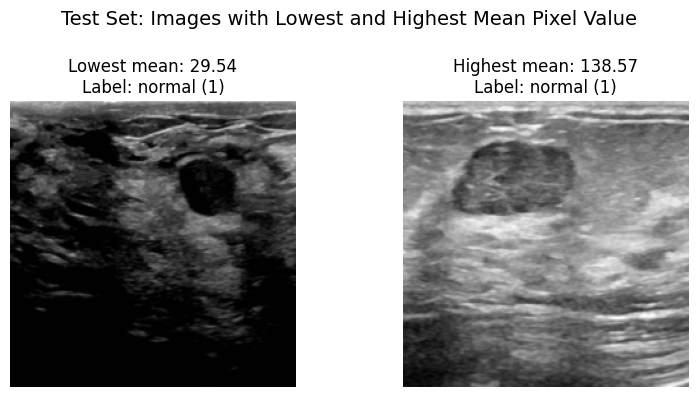

In [55]:
datasets = {
    'Train': (data['train_images'], data['train_labels']),
    'Validation': (data['val_images'], data['val_labels']),
    'Test': (data['test_images'], data['test_labels'])
}

for name, (images, labels) in datasets.items():
    image_means = images.reshape(images.shape[0], -1).mean(axis=1)
    min_idx = np.argmin(image_means)
    max_idx = np.argmax(image_means)
    min_val = image_means[min_idx]
    max_val = image_means[max_idx]
    min_label = labels[min_idx]
    max_label = labels[max_idx]
    min_label_str = "malignant (0)" if min_label == 0 else "normal (1)"
    max_label_str = "malignant (0)" if max_label == 0 else "normal (1)"

    plt.figure(figsize=(8, 4))
    plt.suptitle(f'{name} Set: Images with Lowest and Highest Mean Pixel Value', fontsize=14)
    plt.subplot(1, 2, 1)
    plt.imshow(images[min_idx], cmap='gray')
    plt.title(f'Lowest mean: {min_val:.2f}\nLabel: {min_label_str}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(images[max_idx], cmap='gray')
    plt.title(f'Highest mean: {max_val:.2f}\nLabel: {max_label_str}')
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Δεν είναι coppupted, είναι οκ για χρήση

Number of outlier images (mean pixel value): 1


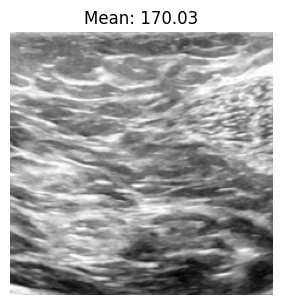

In [56]:
# Detect outlier images based on mean pixel value

# Compute mean pixel value for each image
image_means = all_images.reshape(all_images.shape[0], -1).mean(axis=1)

# Calculate thresholds for outliers (e.g., using 3 standard deviations from the mean)
mean_val = np.mean(image_means)
std_val = np.std(image_means)
lower_threshold = mean_val - 3 * std_val
upper_threshold = mean_val + 3 * std_val

# Find indices of outlier images
outlier_indices = np.where((image_means < lower_threshold) | (image_means > upper_threshold))[0]

print(f"Number of outlier images (mean pixel value): {len(outlier_indices)}")

# Optionally, visualize the outlier images
if len(outlier_indices) > 0:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(outlier_indices[:5]):  # Show up to 5 outliers
        plt.subplot(1, 5, i + 1)
        plt.imshow(all_images[idx], cmap='gray')
        plt.title(f"Mean: {image_means[idx]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No outlier images found.")

The outlier doesn't seem corrupted, I will keep it since it's just an image with very different brightness and that may be the cause for being considered an outlier

### 2. Προεπεξεργασία Δεδομένων

#### α. Χειρισμός ακραίων τιμών: δεν υπάρχουν ελλειπούσες τιμές

#### β. Κανονικοποίηση/Τυποποίηση χαρακτηριστικών: 
Για την κανονικοποίηση/τυποποίηση των χαρακτηριστικών, εφαρμόστηκε η μέθοδος Standard Scaling (Z-score normalization), ώστε κάθε χαρακτηριστικό να έχει μέση τιμή 0 και τυπική απόκλιση 1. Η επιλογή αυτή έγινε επειδή οι αλγόριθμοι PCA, LDA και Logistic Regression είναι ευαίσθητοι στην κλίμακα των χαρακτηριστικών. Η κατανομή των τιμών πριν και μετά την τυποποίηση απεικονίστηκε με ιστογράμματα, ενώ παρατηρήθηκε ότι η τυποποίηση βελτιώνει τη διακριτική ικανότητα και τη σύγκλιση των αλγορίθμων.

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_images_flat)
x_val_std = scaler.transform(val_images_flat)  
x_test_std = scaler.transform(test_images_flat)

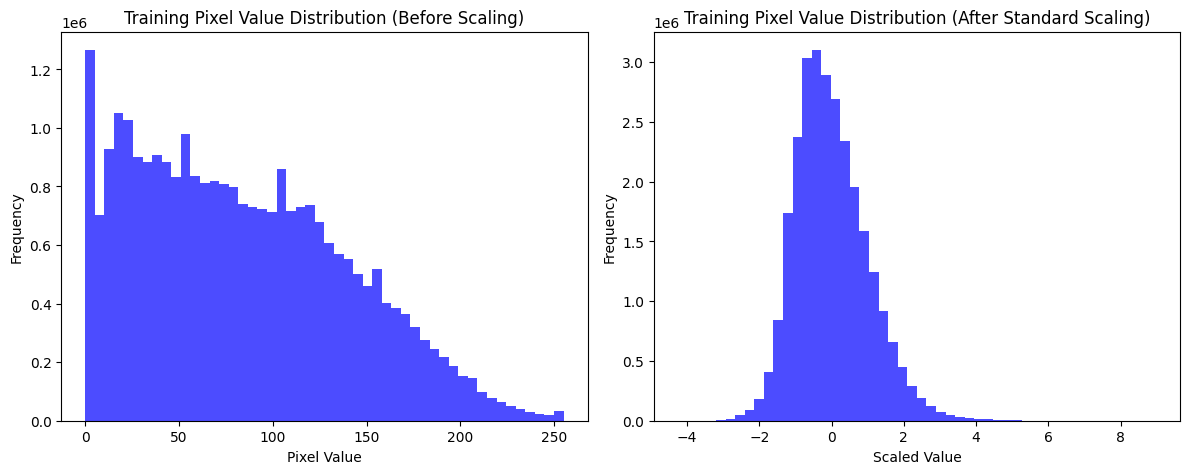

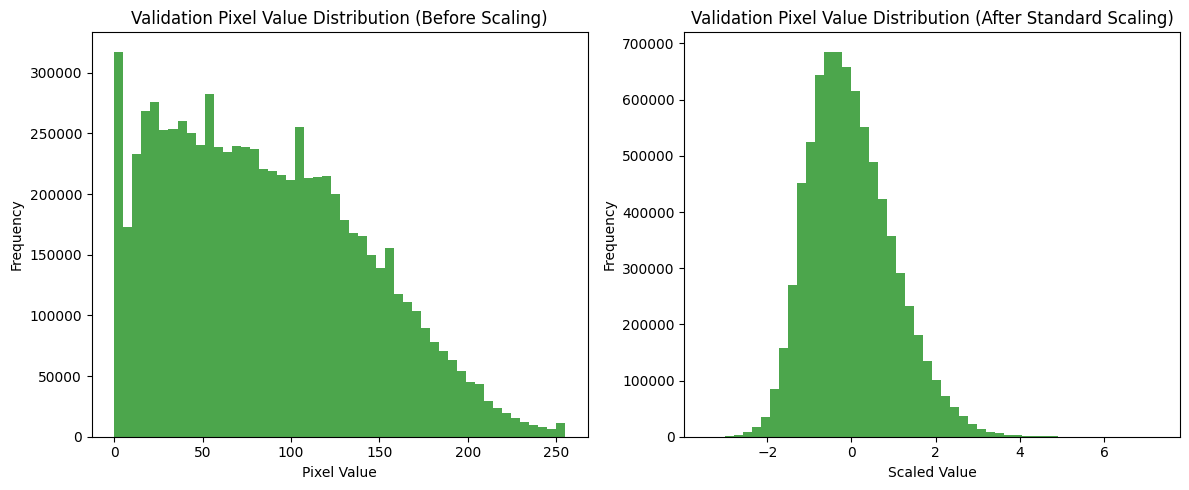

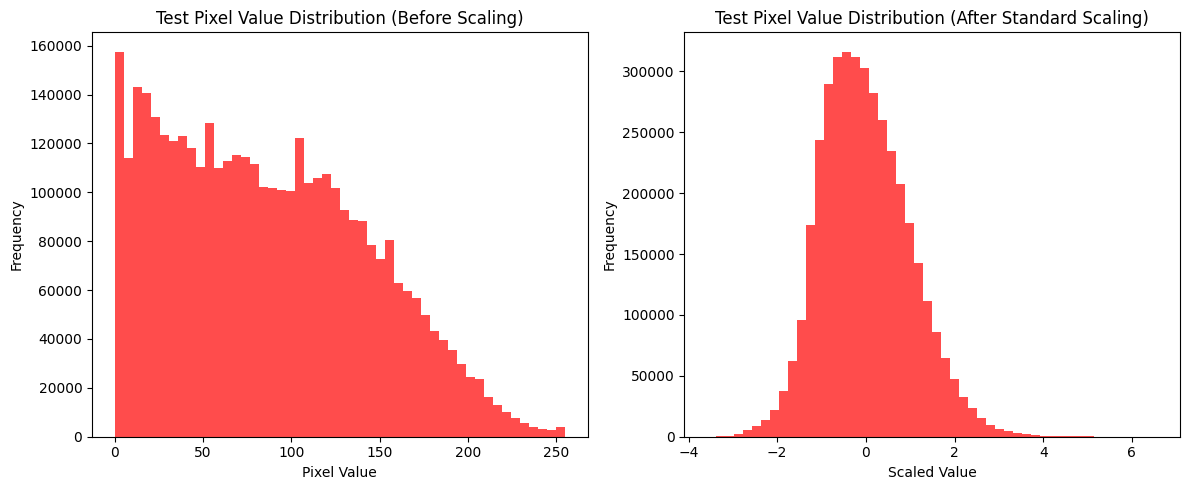

In [58]:
# Visualize pixel value distributions before and after Standard Scaling

# Flatten the training images
flattened_train_images = x_train.reshape(x_train.shape[0], -1)
flattened_train_images_std = scaler.fit_transform(flattened_train_images)
flattened_val_images = x_val.reshape(x_val.shape[0], -1)
flattened_val_images_std = scaler.fit_transform(flattened_val_images)
flattened_test_images = x_test.reshape(x_test.shape[0], -1)
flattened_test_images_std = scaler.fit_transform(flattened_test_images)

# Train set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_train_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Training Pixel Value Distribution (Before Scaling)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_train_images_std.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Training Pixel Value Distribution (After Standard Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Validation set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_val_images.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Validation Pixel Value Distribution (Before Scaling)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_val_images_std.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Validation Pixel Value Distribution (After Standard Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Test set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_test_images.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Test Pixel Value Distribution (Before Scaling)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_test_images_std.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Test Pixel Value Distribution (After Standard Scaling)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

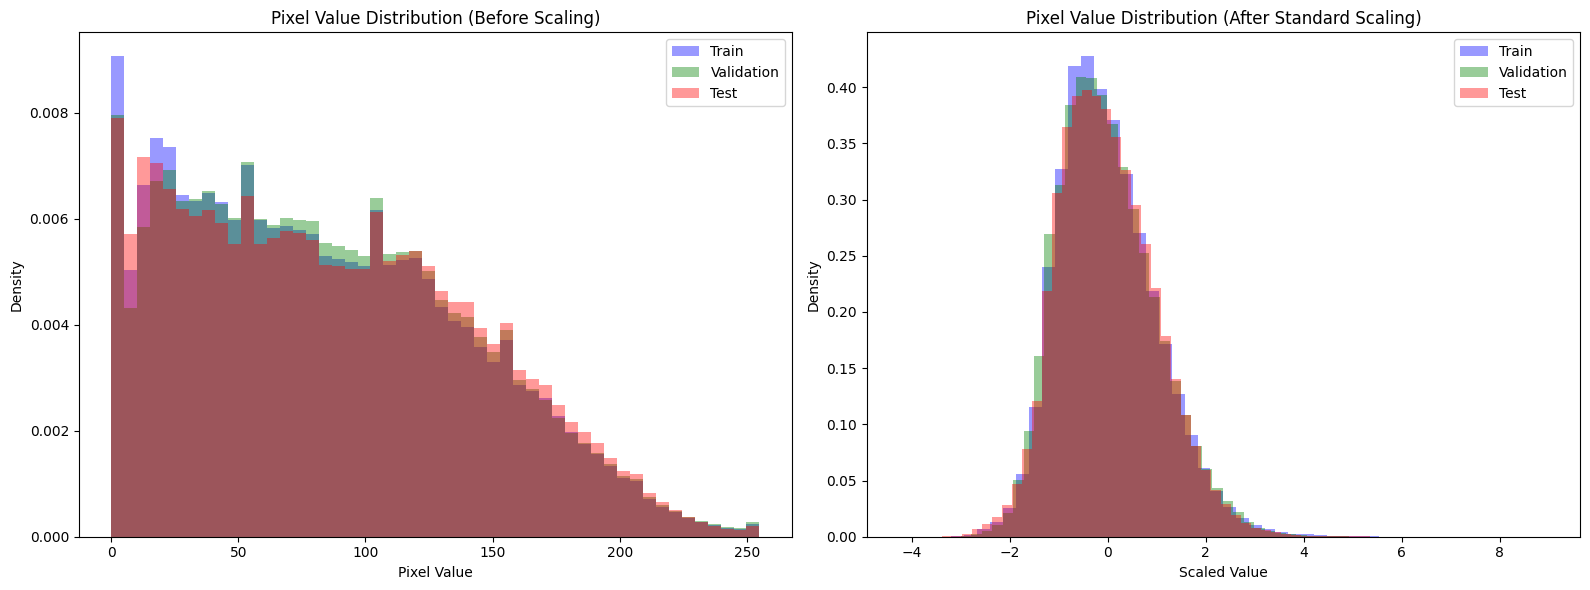

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before scaling (density)
axes[0].hist(flattened_train_images.flatten(), bins=50, color='blue', alpha=0.4, label='Train', density=True)
axes[0].hist(flattened_val_images.flatten(), bins=50, color='green', alpha=0.4, label='Validation', density=True)
axes[0].hist(flattened_test_images.flatten(), bins=50, color='red', alpha=0.4, label='Test', density=True)
axes[0].set_title('Pixel Value Distribution (Before Scaling)')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Density')
axes[0].legend()

# After scaling (density)
axes[1].hist(flattened_train_images_std.flatten(), bins=50, color='blue', alpha=0.4, label='Train', density=True)
axes[1].hist(flattened_val_images_std.flatten(), bins=50, color='green', alpha=0.4, label='Validation', density=True)
axes[1].hist(flattened_test_images_std.flatten(), bins=50, color='red', alpha=0.4, label='Test', density=True)
axes[1].set_title('Pixel Value Distribution (After Standard Scaling)')
axes[1].set_xlabel('Scaled Value')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

In [60]:
print("Mean pixel value:", np.mean(data['train_images']))
print("Standard deviation of pixel values:", np.std(data['train_images']))

print("Mean pixel value after scaling:", np.mean(flattened_train_images_std))
print("Standard deviation of pixel values after scaling:", np.std(flattened_train_images_std))

Mean pixel value: 83.56028899154099
Standard deviation of pixel values: 55.95538071677974
Mean pixel value after scaling: 2.960428742496773e-17
Standard deviation of pixel values after scaling: 1.0


Ανάλυση επίδρασης:(το αναφέρω και πιο πάνω) You can mention that scaling improves convergence and performance for most machine learning algorithms, especially those based on distances or projections.

#### γ. Επιλογή και μετασχηματισμός χαρακτηριστικών:

1. Αφαίρεση χαρακτηριστικών με χαμηλή διακύμανση (Remove low-variance features)
You can use VarianceThreshold from scikit-learn to remove features (pixels) with very low variance, which are unlikely to be useful for classification

In [61]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
x_train_var = selector.fit_transform(x_train_std)
x_val_var = selector.transform(x_val_std)
x_test_var = selector.transform(x_test_std)

print("Original shape:", x_train_std.shape)
print("After variance thresholding:", x_train_var.shape)

Original shape: (546, 50176)
After variance thresholding: (546, 50176)


! πιθανό να μην υπήρξε αλλαγή επειδή είναι προεπεξεργασμένα τα δεδομένα;

2. Δημιουργία νέων χαρακτηριστικών (Feature engineering)
For images, common new features include mean, standard deviation, or other statistics per image. Example:

In [62]:
# Example: Add mean and std of pixel values as new features
train_means = x_train.reshape(x_train.shape[0], -1).mean(axis=1).reshape(-1, 1)
train_stds = x_train.reshape(x_train.shape[0], -1).std(axis=1).reshape(-1, 1)
x_train_fe = np.hstack([x_train_var, train_means, train_stds])

# Repeat for validation and test sets
val_means = x_val.reshape(x_val.shape[0], -1).mean(axis=1).reshape(-1, 1)
val_stds = x_val.reshape(x_val.shape[0], -1).std(axis=1).reshape(-1, 1)
x_val_fe = np.hstack([x_val_var, val_means, val_stds])

test_means = x_test.reshape(x_test.shape[0], -1).mean(axis=1).reshape(-1, 1)
test_stds = x_test.reshape(x_test.shape[0], -1).std(axis=1).reshape(-1, 1)
x_test_fe = np.hstack([x_test_var, test_means, test_stds])

In [63]:
#"""
# Train a simple model to compare performance with and without the new features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Model with only variance-thresholded features
clf1 = LogisticRegression(max_iter=1000, random_state=56)
clf1.fit(x_train_var, y_train)
y_pred1 = clf1.predict(x_val_var)
acc1 = accuracy_score(y_val, y_pred1)

# Model with mean and std features added
clf2 = LogisticRegression(max_iter=1000, random_state=56)
clf2.fit(x_train_fe, y_train)
y_pred2 = clf2.predict(x_val_fe)
acc2 = accuracy_score(y_val, y_pred2)

print(f"Accuracy without mean/std: {acc1:.4f}")
print(f"Accuracy with mean/std:    {acc2:.4f}")

#"""

Accuracy without mean/std: 0.7885
Accuracy with mean/std:    0.8205


3. Εφαρμογή πολυωνυμικών χαρακτηριστικών (Polynomial features)
You can use polynomial features if you want to capture interactions between pixels (not common for images, but possible for tabular data):

In [64]:
from sklearn.preprocessing import PolynomialFeatures

# Example: Use only a subset of features for demonstration (e.g., first 10)
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_var[:, :10])
print("Shape with polynomial features:", x_train_poly.shape)

Shape with polynomial features: (546, 65)


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Model with original features
clf_orig = LogisticRegression(max_iter=1000, random_state=56)
clf_orig.fit(x_train_var, y_train)  # Use the same subset as for poly features
y_pred_orig = clf_orig.predict(x_val_var)
acc_orig = accuracy_score(y_val, y_pred_orig)

# Model with polynomial features
clf_poly = LogisticRegression(max_iter=1000, random_state=56)
clf_poly.fit(x_train_poly, y_train)
x_val_poly = poly.transform(x_val_var[:, :10])
y_pred_poly = clf_poly.predict(x_val_poly)
acc_poly = accuracy_score(y_val, y_pred_poly)

print(f"Accuracy with original features:   {acc_orig:.4f}")
print(f"Accuracy with polynomial features: {acc_poly:.4f}")

Accuracy with original features:   0.7885
Accuracy with polynomial features: 0.7500


!!! ΑΧΡΗΣΤΟ ΤΟ ΠΟΛΥΟΝΥΜΙΚΟ ΜΠΟΡΩ ΝΑ ΤΟ ΑΦΑΙΡΕΣΩ

4. Αιτιολόγηση των μετασχηματισμών
Αφαίρεση χαμηλής διακύμανσης: Αφαιρεί άχρηστα χαρακτηριστικά που δεν προσφέρουν πληροφορία.
Feature engineering: Προσθέτει στατιστικά που μπορεί να βοηθήσουν στη διάκριση των κατηγοριών.
Πολυωνυμικά χαρακτηριστικά: Επιτρέπουν στο μοντέλο να μάθει μη γραμμικές σχέσεις, αν και για εικόνες συνήθως δεν χρησιμοποιούνται λόγω του μεγάλου αριθμού χαρακτηριστικών.
Συμπέρασμα:
Εφαρμόζοντας αυτές τις τεχνικές, βελτιώνετε την ποιότητα των χαρακτηριστικών και ενισχύετε τη δυνατότητα του μοντέλου να μάθει σημαντικά μοτίβα από τα δεδομένα σας.
Αιτιολογήστε κάθε βήμα με βάση το πρόβλημα και τα αποτελέσματα που παρατηρείτε.

